# Laboratorio 7: Poke-ensambles

**Duración:** 2 horas  
**Formato:** Competencia por equipos con rotaciones y
kahoots Pokemon  
**Repositorio base:** [_link al repo oficial_](https://github.com/JAlbertoAlonso/poke-ensambles/tree/main)

---

## Portada del equipo

**Integrantes:**
- Luis Enrique Morales Flores (lukemorales13)
- Emil Ehecatl Sánchez Olsen (Emilehecatlsanchez)
- Fabián Herrera Barrón (FabianHeBa)
- Vania Janet Raya Rios (Vania-Janet)

**Repositorio del equipo:**  
<https://github.com/lukemorales13/Ensambles-de-Votaci-n-con-PokeAPI>

**Fecha de entrega:**  
25/10/2025

## Elemento 1 - Construcción del dataset (Infraestructura)

## Elemento 2 - Entrenamiento de modelos base (Modelado)

Este esta parte se implementa **la parte de modelación** indicada para la Computadora B, siguiendo la guía del laboratorio:
- Entrena **modelos base** (no-ensambles) con `scikit-learn`: Regresión Logística, Árbol de Decisión, KNN y SVM.



### Rutas y parámetros principales


In [2]:
from pathlib import Path

DATASET_TRAIN_CSV = Path(r"..\data\dataset.csv")  
DATASET_TEST_CSV  = Path(r"..\data\testset.csv")   

TEAM_NAME  = "Charmander"
VOTER_NAME = "VotacionPonderada"  

RANDOM_STATE = 42



## Carga y preparación de datos

- Seleccionamos las **features permitidos**.
- Codificamos la **categoría** `primary_type` con One-Hot.
- Escalamos las variables numéricas.
- Partimos en `train/valid` para estimar pesos del votador ponderado.


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(DATASET_TRAIN_CSV)

feature_cols = ["height", "weight", "base_experience", "primary_type"]
target_col   = "strong"

missing_cols = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas en el dataset de entrenamiento: {missing_cols}")

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()
id_col = "id" if "id" in df.columns else None

num_cols  = ["height", "weight", "base_experience"]
cat_cols  = ["primary_type"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Tamaños -> Train:", X_train.shape, "Valid:", X_valid.shape)


Tamaños -> Train: (400, 4) Valid: (100, 4)



## 2) Modelos base

Entrenaremos cuatro modelos individuales (no-ensambles):
- **Regresión Logística**
- **Árbol de Decisión**
- **KNN**
- **SVM** (con `probability=True` para **votación suave** y **ponderada**)



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

logreg_params = dict(C=1.0, max_iter=200)
tree_params   = dict(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE)
knn_params    = dict(n_neighbors=15, weights="distance") 
svm_params    = dict(C=1.0, kernel="rbf", probability=True, random_state=RANDOM_STATE)

models = {
    "logreg": Pipeline([("prep", preprocess), ("clf", LogisticRegression(**logreg_params))]),
    "tree":   Pipeline([("prep", preprocess), ("clf", DecisionTreeClassifier(**tree_params))]),
    "knn":    Pipeline([("prep", preprocess), ("clf", KNeighborsClassifier(**knn_params))]),
    "svm":    Pipeline([("prep", preprocess), ("clf", SVC(**svm_params))]),
}

# Entrenamiento
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
print("Modelos entrenados.")


Modelos entrenados.


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_binary(y_true, y_pred):
    return dict(
        accuracy = accuracy_score(y_true, y_pred),
        precision= precision_score(y_true, y_pred, zero_division=0),
        recall   = recall_score(y_true, y_pred, zero_division=0),
        f1       = f1_score(y_true, y_pred, zero_division=0),
    )

import pandas as pd
metrics_rows = []
preds_valid = {}
proba_valid = {}

for name, pipe in models.items():
    yp = pipe.predict(X_valid)
    preds_valid[name] = yp
    metrics = eval_binary(y_valid, yp)
    metrics_rows.append({"model": name, **metrics})
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_valid[name] = pipe.predict_proba(X_valid)[:, 1]
    else:
        proba_valid[name] = yp.astype(float)

metrics_df = pd.DataFrame(metrics_rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
metrics_df


,model,accuracy,precision,recall,f1
0,tree,1.00,1.0,1.00,1.000000
1,knn,1.00,1.0,1.00,1.000000
2,svm,0.93,1.0,0.72,0.837209
3,logreg,0.91,0.9,0.72,0.800000


In [6]:
proba_valid

{'logreg': array([3.67930033e-01, 8.68789639e-01, 2.23819691e-01, 6.43891519e-04,
        3.69865874e-02, 1.65558999e-01, 4.08729108e-01, 2.34567737e-03,
        1.04301696e-01, 1.02878473e-03, 4.23293008e-01, 5.56541383e-01,
        1.60856453e-01, 9.96171444e-01, 2.48848674e-01, 8.88577687e-01,
        1.22804167e-02, 9.99420411e-01, 1.48770573e-01, 2.34793854e-03,
        6.86442238e-03, 5.98102703e-03, 3.57607250e-03, 3.44382052e-01,
        3.33721863e-02, 1.08331064e-01, 4.20928307e-01, 8.29520366e-02,
        3.42580103e-01, 9.98173786e-01, 6.61954052e-02, 1.11578305e-01,
        3.86245679e-02, 1.52157681e-03, 1.68951102e-03, 3.52243596e-02,
        3.33352111e-04, 8.44973485e-02, 1.42649773e-03, 1.13590840e-01,
        9.32258858e-01, 4.11235506e-03, 7.08685817e-01, 1.38314933e-01,
        7.06029269e-02, 1.19170294e-01, 1.92503438e-01, 6.21603022e-01,
        1.05191556e-03, 6.22878133e-02, 1.30107392e-03, 2.35624985e-01,
        9.99999880e-01, 9.46866124e-01, 1.15870629e-03

## Elemento 3 - Ensambles de votación

Se implementan funciones puras para:
- **Votación dura**: mayoría sobre predicciones 0/1.
- **Votación suave**: promedio de probabilidades `P(y=1|x)` y umbral 0.5.
- **Votación ponderada**: promedio ponderado de probabilidades usando pesos ∝ exactitud en validación de cada modelo.


In [7]:
import numpy as np

def vote_hard(pred_dict):
    base = list(pred_dict.values())
    stacked = np.vstack(base).astype(int)
    votes = stacked.sum(axis=0)
    yhat  = (votes > (stacked.shape[0] / 2)).astype(int)
    return yhat

def vote_soft(proba_dict):
    base = list(proba_dict.values())
    stacked = np.vstack(base)  
    avg = stacked.mean(axis=0)
    return (avg >= 0.5).astype(int), avg

def vote_weighted(proba_dict, weights):
    keys = list(proba_dict.keys())
    w = np.array([weights[k] for k in keys], dtype=float)
    w = w / (w.sum() + 1e-12)
    stacked = np.vstack([proba_dict[k] for k in keys])  
    wavg = (w[:, None] * stacked).sum(axis=0)
    return (wavg >= 0.5).astype(int), wavg

# Pesos proporcionales a la exactitud en validación
accs = {row["model"]: row["accuracy"] for _, row in metrics_df.iterrows()}
accs


{'tree': 0.98, 'svm': 0.92, 'logreg': 0.91, 'knn': 0.89}

## Elemento 4 - Evaluación y competencia

Se muestran métricas: exactitud, precisión, recall y F1. Además, se grafica la matriz de confusión por votador.


### Métricas de votadores (validación)

,voter,accuracy,precision,recall,f1
0,soft,0.96,1.0,0.84,0.913043
1,weighted,0.96,1.0,0.84,0.913043
2,hard,0.92,1.0,0.68,0.809524


<Figure size 640x480 with 0 Axes>

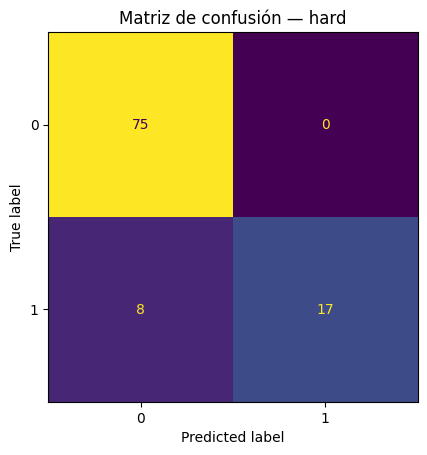

<Figure size 640x480 with 0 Axes>

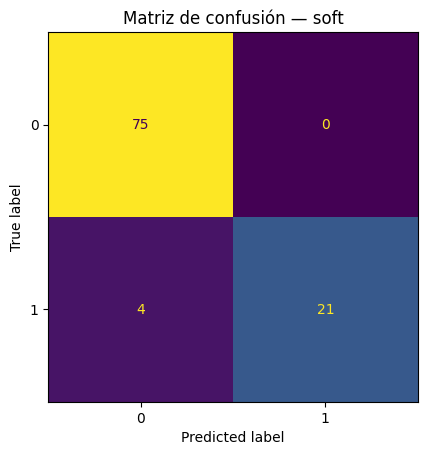

<Figure size 640x480 with 0 Axes>

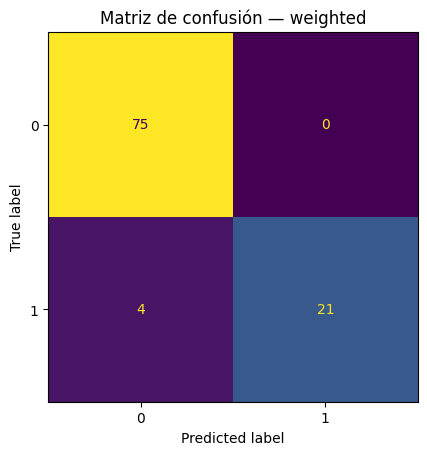

,voter,accuracy,precision,recall,f1
0,soft,0.96,1.0,0.84,0.913043
1,weighted,0.96,1.0,0.84,0.913043
2,hard,0.92,1.0,0.68,0.809524


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

yhat_hard = vote_hard(preds_valid)
m_hard = eval_binary(y_valid, yhat_hard)

yhat_soft, soft_scores = vote_soft(proba_valid)
m_soft = eval_binary(y_valid, yhat_soft)

yhat_w, w_scores = vote_weighted(proba_valid, accs)
m_w = eval_binary(y_valid, yhat_w)

ens_metrics = pd.DataFrame([
    {"voter":"hard", **m_hard},
    {"voter":"soft", **m_soft},
    {"voter":"weighted", **m_w},
]).sort_values("accuracy", ascending=False).reset_index(drop=True)

from IPython.display import display, Markdown

display(Markdown("### Métricas de votadores (validación)"))
display(ens_metrics)


for voter_name, yhat in [("hard", yhat_hard), ("soft", yhat_soft), ("weighted", yhat_w)]:
    cm = confusion_matrix(y_valid, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot(values_format='d', colorbar=False)  
    plt.title(f"Matriz de confusión — {voter_name}")
    plt.show()

ens_metrics


In [9]:
ens_metrics

,voter,accuracy,precision,recall,f1
0,soft,0.96,1.0,0.84,0.913043
1,weighted,0.96,1.0,0.84,0.913043
2,hard,0.92,1.0,0.68,0.809524



## Reentrenar en todo el set de entrenamiento

Tras seleccionar el votador final, reentrenamos cada modelo base en **todo el train** (train+valid) para aprovechar al máximo los datos.


In [11]:
for name, pipe in models.items():
    pipe.fit(X, y)
print("Modelos reentrenados en todo el dataset de entrenamiento.")


Modelos reentrenados en todo el dataset de entrenamiento.



## Predicción sobre el test set y archivo de competencia

Generamos el archivo:  
`id,y_pred,EquipoNombre,VotacionTipo` en la primera fila y las filas siguientes solo con `id,y_pred`.


In [12]:
test_df = pd.read_csv(DATASET_TEST_CSV)

test_id_col = "id" if "id" in test_df.columns else None
if test_id_col is None:
    test_ids = np.arange(len(test_df))
else:
    test_ids = test_df[test_id_col].values

missing_cols_test = [c for c in ["height","weight","base_experience","primary_type"] if c not in test_df.columns]
if missing_cols_test:
    raise ValueError(f"Faltan columnas en el dataset de test: {missing_cols_test}")

X_test = test_df[["height","weight","base_experience","primary_type"]].copy()

preds_test = {}
proba_test = {}
for name, pipe in models.items():
    yp = pipe.predict(X_test)
    preds_test[name] = yp
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_test[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        proba_test[name] = yp.astype(float)

VOTER_NAME = VOTER_NAME.strip()

if VOTER_NAME.lower() == "votaciondura":
    y_pred_final = vote_hard(preds_test)
elif VOTER_NAME.lower() == "votacionsuave":
    y_pred_final, _ = vote_soft(proba_test)
elif VOTER_NAME.lower() == "votacionponderada":
    y_pred_final, _ = vote_weighted(proba_test, accs)
else:
    raise ValueError("VOTER_NAME inválido. Usa: VotacionDura, VotacionSuave o VotacionPonderada")

# Archivo de competencia
import csv
out_path = Path("predicciones_competencia.csv")
with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "y_pred", TEAM_NAME, VOTER_NAME])
    for i, (rid, yhat) in enumerate(zip(test_ids, y_pred_final)):
        writer.writerow([rid, int(yhat), "", ""])

print(f"Archivo de competencia escrito en: {out_path}")
out_path


Archivo de competencia escrito en: predicciones_competencia.csv


WindowsPath('predicciones_competencia.csv')

In [13]:
output = pd.read_csv("predicciones_competencia.csv")
output.head()

,id,y_pred,Charmander,VotacionPonderada
0,894,1,NaN,NaN
1,981,1,NaN,NaN
2,755,0,NaN,NaN
3,73,1,NaN,NaN
4,931,0,NaN,NaN
